# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*
- [ ] controllare se ad alte frequenze se le oscillazioni si vedono anche sull'oscilloscopio
- [ ] CHIEDERE RIGUARDO AI BATTIMENTI (ES SWEEP 39)



In [1]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *

# Setup parameters

In [2]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

# parameters for the Signal Generator
f_min           = 51e6                                  # tryout value
f_max           = 100e6                                  # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -10                           # Set the amplitude of the signal in dBm

pulse_width     = 5                                 # 2 microsec
pulse_delay     = 5
pulse_period    = 1000  


sGen.reset()
sGen.clear()
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate # Maximum Value: 250.0e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

Error: No active connection.
Error: No active connection.
Error: No active connection.
Error: No active connection.
Error: No active connection.
Error: No active connection.
Error: No active connection.
Error: No active connection.


# Acquisition of signals for each frequency in the range

In [3]:

slip = 0.0      # time of sleep of triggering

fetched_data = []

while True:
# for i in pulse_freq:
#     #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
#     sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.1)
    # wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
#     fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]

# print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


Error: No active connection.
Error: No active connection.


AttributeError: 'NoneType' object has no attribute 'write'

# Plot of a sweep with the peaks of amplitudes marked

In [9]:
def data_amps(y: np.array, toggle_plot = True):
    x = np.arange(len(y))/sample_rate
    std = np.std(y)
    indices = find_peaks(y, prominence=2*(max(y) - std))
    idx = indices[0]
    offset = 5
    idx = idx[offset:-offset]
    
    if toggle_plot:
        # plt.clf()
        plt.grid()
        plt.plot(x, y)
        plt.scatter(x[idx],y[idx], color = 'orange')
        plt.draw()
    # return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}
    return (x, idx)

# Save data on HDF5 file

In [ ]:
# with h5py.File('nonloso_2.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

In [5]:
fetched_data = []
with h5py.File('nonloso_2.hdf5', 'r') as f:
    
    for j in range(len(f)):
        dic = {}
        gp = f[str(j)]
        for i, k in gp.items():
            dic[i] = k[()]
        fetched_data += [dic]


# First Data Analysis tryout

In [ ]:
# offset = 2.5e-6
# end = 5e-6

# with h5py.File('nonloso.hdf5', 'r'):
    

In [ ]:
# amps = []
# with h5py.File('nonloso_2.hdf5', 'r') as f:
#     for j in range(1,len(f)):
#         gp = f[str(j)]
#         dic = {}
#         for i, k in gp.items():
#             dic[i] = k[()]
#         freq = dic['freq']
#         data = dic['data']

            
#         amps = amps + [data_amps(data, False)['mean']]


# plt.clf()
# plt.plot(amps)
# plt.show()

15

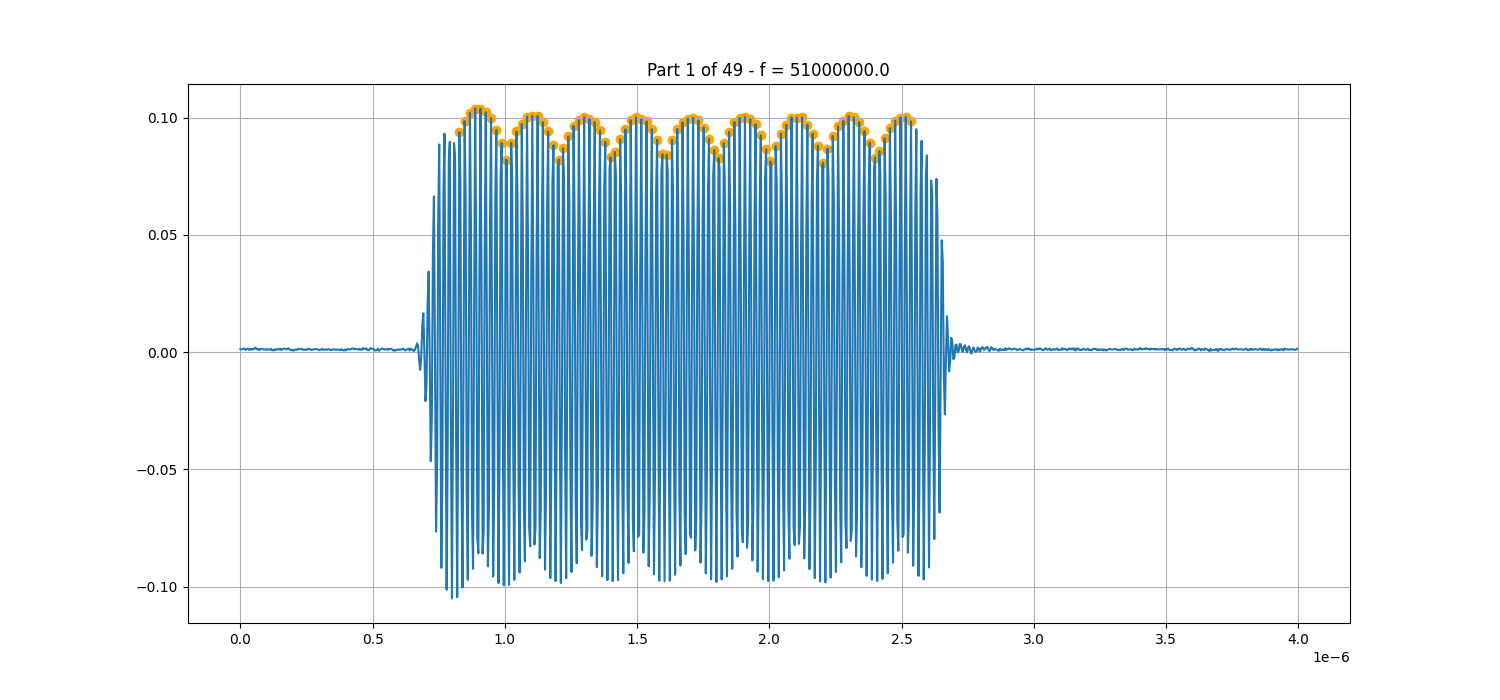

In [145]:
sweep = 0
f_chosen = fetched_data[sweep]
f = f_chosen['freq']
y = np.array(f_chosen['data'])
fig = plt.subplots(figsize = (15,7))[0]
plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
x, idx = data_amps(y, toggle_plot = True)

def on_key(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data):
        sweep = 0
    elif sweep == -1:
        sweep = len(fetched_data)-1

    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    x, idx = data_amps(y, toggle_plot = False)

    # clear frame
    plt.clf()
    plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
    plt.grid()
    plt.plot(x, y)
    plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw

fig.canvas.mpl_connect('key_press_event',on_key)

# Demodulation with FT

In [153]:
def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))


    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6
    mask = (freqs < (freq+offset)) & (freqs > (freq-offset))
    max = np.max(FT[mask])
    phi = PHI[np.where(FT == max)]




    FT = np.fft.fft(y * np.cos(x*freq*2*np.pi + phi))
    print(FT)
    freqs = np.fft.fftfreq(N,T)  
    region_mask = (freqs >= -0.3e8) & (freqs <= 0.3e8)
    x_region = FT.copy()
    x_region[~region_mask] = 0
    IFT = np.fft.ifft(x_region*2)

    if toggle_plot:
        plt.clf()
        
        # plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
        plt.plot(freqs,np.abs(FT))
        plt.subplot(1,2,2)
        plt.plot(IFT)
        plt.draw()

[-2.10683434e+01+0.00000000e+00j  1.21509703e+01+6.63861646e+00j
 -3.05438951e-01-6.25335028e-01j -4.00427125e-01-4.59506856e+00j
 -3.88021150e-01+6.56209981e-01j -2.08617603e+00+1.72888944e+00j
  7.85514964e-01-7.47368783e-02j  1.77121546e+00+4.84022667e-01j
 -5.20450977e-01-5.87436923e-01j -4.44155620e-01-1.23233494e+00j
 -1.62213489e-01+7.35998622e-01j -5.55495466e-01+7.87100716e-01j
  6.54553740e-01-2.87551076e-01j  7.07218576e-01+1.28619896e-02j
 -5.59960945e-01-3.50624667e-01j -2.87635561e-01-4.40354755e-01j
  3.70316137e-02+6.03846283e-01j -1.49264469e-01+3.39324746e-01j
  4.42903309e-01-3.32005726e-01j  2.56628610e-01-4.95204812e-02j
 -4.71255988e-01-1.52968254e-01j -1.25543492e-01-1.37340910e-01j
  1.28501666e-01+4.25601635e-01j -3.42167289e-02+1.14520057e-01j
  2.55066683e-01-3.09424208e-01j  6.43798664e-02-9.08792749e-03j
 -3.49194359e-01-2.38517399e-02j -2.51000936e-02-2.16791798e-02j
  1.63439556e-01+2.64976239e-01j -1.13440306e-02+9.56169871e-03j
  1.01020369e-01-2.495075

c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


15

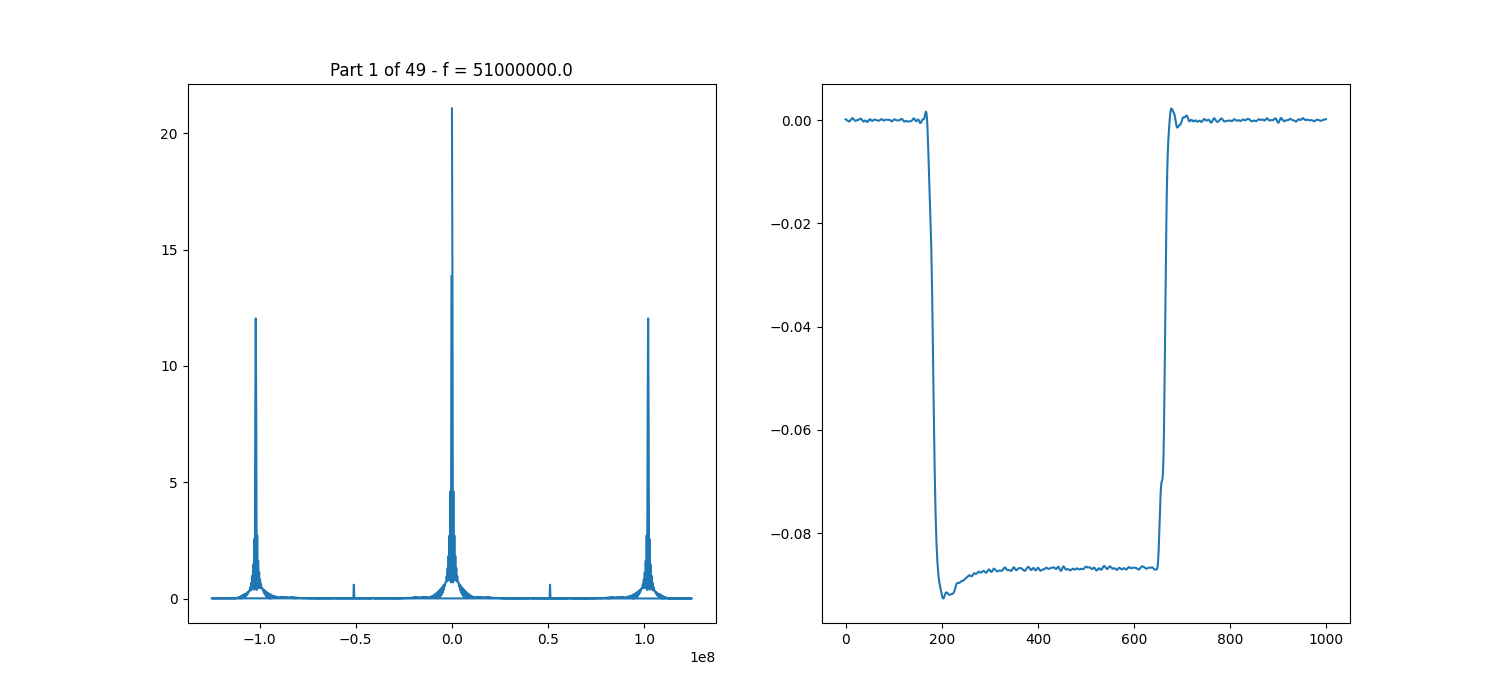

[-2.09862052e+01+0.00000000e+00j  1.20683471e+01+6.63279504e+00j
 -2.78067359e-01-5.83234532e-01j -3.46518654e-01-4.58992002e+00j
 -3.82253538e-01+6.00076614e-01j -2.11914524e+00+1.70286248e+00j
  7.50345221e-01-4.65871662e-02j  1.76440180e+00+5.24501595e-01j
 -4.83791626e-01-5.84423950e-01j -4.09765192e-01-1.26302911e+00j
 -1.82703386e-01+6.92912480e-01j -6.05813165e-01+7.83795556e-01j
  6.46846507e-01-2.45625493e-01j  7.46504248e-01+5.39104092e-02j
 -5.27606160e-01-3.70293880e-01j -2.76814396e-01-4.79833228e-01j
 -2.02235008e-03+6.00046683e-01j -1.79411982e-01+3.66611745e-01j
  4.45377836e-01-3.13330525e-01j  2.99301288e-01-3.11782464e-02j
 -4.68050007e-01-1.77569069e-01j -1.38995153e-01-1.63654575e-01j
  1.07183254e-01+4.34381031e-01j -5.38075402e-02+1.48346930e-01j
  2.76292259e-01-3.00592302e-01j  1.05037656e-01-2.26719203e-02j
 -3.54875957e-01-3.70334899e-02j -4.90664864e-02-4.23649260e-02j
  1.60589083e-01+2.72161455e-01j -1.10024067e-02+3.13524564e-02j
  1.14020760e-01-2.481573

In [154]:
sweep = 0
sample_rate        = 250e6 # Maximum Value: 250.0e6

f_chosen = fetched_data[sweep]
f       = f_chosen['freq']
data    = f_chosen['data']

fig2 = plt.subplots(figsize = (15,7))[0]

y = np.array(data)
x = np.arange(len(y))/sample_rate


data_fft(y, f, sample_rate, True)

def on_key_fft(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data):
        sweep = 0
    elif sweep == -1:
        sweep = len(fetched_data)-1

    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    data_fft(y, f_chosen['freq'], sample_rate, True) 

    # # clear frame
    # plt.clf()
    # plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
    # plt.grid()
    # plt.plot(x, y)
    # plt.draw() # redraw

fig2.canvas.mpl_connect('key_press_event',on_key_fft)

- per sistemare il fattore 2, dobbiamo sommare tutto il set FT e dividerlo per il set attorno al picco a f = 0 (integrare tutto e dividere per l'integrale sotto f = 0)
- https://en.wikipedia.org/wiki/Product_detector